In [1]:
import numpy as np
import camb
from camb import model
import scipy
import scipy.stats
from scipy.stats import qmc
import scipy.interpolate as interpolate
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.fftpack import dst, idst
import scipy.integrate
import math
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import sys, platform, os
import matplotlib
import matplotlib.pyplot as plt
import time
import GPy
ee_path = '/home/grads/data/xiao/miniconda/envs/cocoaemu/lib/python3.7/site-packages'
sys.path.insert(0,ee_path)
import euclidemu2 as ee2


Classy could not be found in your system.
Here are some suggestions:

	 -Download the Class from class-code.net and install it
	  together with its wrapper classy (type 'make' instead of
	  'make class'
	 -If you know that Class is installed on your system
	  and yet classy could not be installed, try re-compiling
	  Class with just ''make'' instead of ''make class''
NOTICE: Even without classy you can still use EuclidEmulator2
        to emulate boost factors. You won't be able to compute
        full power spectra, though.


In [2]:
def find_first_minimum(array):
    for i, entry in enumerate(array):
        if i <= 10:
            continue
        else:
            left_neighbor = array[i-1]
            right_neighbor = array[i+1]
            if entry < left_neighbor and entry < right_neighbor:
                return i, entry
        if i == len(array)-1:
            return 'Error'
def find_second_maximum(array):
    maxima = 0
    for i, entry in enumerate(array):
        if i <= 10:
            continue
        else:
            left_neighbor = array[i-1]
            right_neighbor = array[i+1]
            if entry > left_neighbor and entry > right_neighbor:
                maxima += 1
                if maxima == 2:
                    return i, entry
        if i == len(array) - 1:
            return 'Error'
        
def _nowiggles_pk(k_lin=None, pk_lin=None, k_emu=None):
    """De-wiggled linear prediction of the cold matter power spectrum

    The BAO feature is removed by identifying and removing its corresponding
    bump in real space, by means of a DST, and consequently transforming
    back to Fourier space.
    See:
    - Baumann et al 2018 (https://arxiv.org/pdf/1712.08067.pdf)
    - Giblin et al 2019 (https://arxiv.org/pdf/1906.02742.pdf)

    :param k_lin: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              camb are returned, defaults to None
    :type k_lin: array_like, optional
    :param pk_lin: a vector of linear power spectrum computed at k_lin, if None
              camb will be called, defaults to None
    :type pk_lin: array_like, optional

    :param k_emu: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              the emulator are returned, defaults to None
    :type k_emu: array_like, optional

    :return: dewiggled pk computed at k_emu
    :rtype: array_like
    """

    from scipy.fftpack import dst, idst

    nk = int(2**10)
    kmin = k_lin.min()
    kmax = 10
    klin = np.linspace(kmin, kmax, nk)

    pkcamb_cs = interpolate.splrep(np.log(k_lin), np.log(pk_lin), s=0)
    pklin = np.exp(interpolate.splev(np.log(klin), pkcamb_cs, der=0, ext=0))

    f = np.log10(klin * pklin)

    dstpk = dst(f, type=2)

    even = dstpk[0::2]
    odd = dstpk[1::2]

    i_even = np.arange(len(even)).astype(int)
    i_odd = np.arange(len(odd)).astype(int)

    even_cs = interpolate.splrep(i_even, even, s=0)
    odd_cs = interpolate.splrep(i_odd, odd, s=0)

    even_2nd_der = interpolate.splev(i_even, even_cs, der=2, ext=0)
    odd_2nd_der = interpolate.splev(i_odd, odd_cs, der=2, ext=0)

    # these indexes have been fudged for the k-range considered
    # [~1e-4, 10], any other choice would require visual inspection
    imin_even = i_even[100:300][np.argmax(even_2nd_der[100:300])] - 20
    imax_even = i_even[100:300][np.argmin(even_2nd_der[100:300])] + 70
    imin_odd = i_odd[100:300][np.argmax(odd_2nd_der[100:300])] - 20
    imax_odd = i_odd[100:300][np.argmin(odd_2nd_der[100:300])] + 75

    i_even_holed = np.concatenate((i_even[:imin_even], i_even[imax_even:]))
    i_odd_holed = np.concatenate((i_odd[:imin_odd], i_odd[imax_odd:]))

    even_holed = np.concatenate((even[:imin_even], even[imax_even:]))
    odd_holed = np.concatenate((odd[:imin_odd], odd[imax_odd:]))

    even_holed_cs = interpolate.splrep(i_even_holed, even_holed * (i_even_holed+1)**2, s=0)
    odd_holed_cs = interpolate.splrep(i_odd_holed, odd_holed * (i_odd_holed+1)**2, s=0)

    even_smooth = interpolate.splev(i_even, even_holed_cs, der=0, ext=0) / (i_even + 1)**2
    odd_smooth = interpolate.splev(i_odd, odd_holed_cs, der=0, ext=0) / (i_odd + 1)**2

    dstpk_smooth = []
    for ii in range(len(i_even)):
        dstpk_smooth.append(even_smooth[ii])
        dstpk_smooth.append(odd_smooth[ii])
    dstpk_smooth = np.array(dstpk_smooth)

    pksmooth = idst(dstpk_smooth, type=2) / (2 * len(dstpk_smooth))
    pksmooth = 10**(pksmooth) / klin

    k_highk = k_lin[k_lin > 5]
    p_highk = pk_lin[k_lin > 5]

    k_extended = np.concatenate((klin[klin < 5], k_highk))
    p_extended = np.concatenate((pksmooth[klin < 5], p_highk))

    pksmooth_cs = interpolate.splrep(np.log(k_extended), np.log(p_extended), s=0)
    pksmooth_interp = np.exp(interpolate.splev(np.log(k_emu), pksmooth_cs, der=0, ext=0))

    return pksmooth_interp

def _smeared_bao_pk(k_lin=None, pk_lin=None, k_emu=None, pk_lin_emu=None, pk_nw=None, grid=None):
    """Prediction of the cold matter power spectrum using a Boltzmann solver with smeared BAO feature

    :param k_lin: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              camb are returned, defaults to None
    :type k_lin: array_like, optional
    :param pk_lin: a vector of linear power spectrum computed at k_lin, if None
              camb will be called, defaults to None
    :type pk_lin: array_like, optional

    :param k_emu: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              the emulator are returned, defaults to None
    :type k_emu: array_like, optional
    :param pk_emu: a vector of linear power spectrum computed at k_emu, defaults to None
    :type pk_emu: array_like, optional
    :param pk_nw: a vector of no-wiggles power spectrum computed at k_emu, defaults to None
    :type pk_nw: array_like, optional
    :param grid: dictionary with parameter and vector of values where to evaluate the emulator, defaults to None
    :type grid: array_like, optional

    :return: smeared BAO pk computed at k_emu
    :rtype: array_like
    """
    from scipy.integrate import trapz

    if grid is None:
        sigma_star_2 = trapz(k_lin * pk_lin, x=np.log(k_lin)) / (3 * np.pi**2)
        k_star_2 = 1 / sigma_star_2
        G = np.exp(-0.5 * (k_emu**2 / k_star_2))
        if pk_nw is None:
            pk_nw = _nowiggles_pk(k_lin=k_lin, pk_lin=pk_lin, k_emu=k_emu)
    else:
        sigma_star_2 = trapz(k_lin[None,:] * pk_lin, x=np.log(k_lin[None:,]), axis=1) / (3 * np.pi**2)
        k_star_2 = 1 / sigma_star_2
        G = np.exp(-0.5 * (k_emu**2 / k_star_2[:,None]))
        if pk_nw is None:
            pk_nw = np.array([_nowiggles_pk(k_lin=k_lin, pk_lin=pkl, k_emu=k_emu) for pkl in pk_lin])
    return pk_lin_emu * G + pk_nw * (1 - G)        
        
def smooth_bao(ks, pk):
    spline_loglog_pk = CubicSpline(np.log(ks), np.log(pk))
    n = 10
    dst_ks = np.linspace(ks[0], ks[-1], 2**n)
    logks = np.log(dst_ks)
    logkpk = logks + spline_loglog_pk(logks)
    sine_transf_logkpk = dst(logkpk, type=2, norm='ortho')
    odds = [] # odd entries
    evens = [] # even entries
    even_is = [] # odd indices
    odd_is = [] # even indices
    all_is = [] # all indices
    for i, entry in enumerate(sine_transf_logkpk):
        all_is.append(i)
        if i%2 == 0:
            even_is.append(i)
            evens.append(entry)
        else:
            odd_is.append(i)
            odds.append(entry)
    odd_is = np.array(odd_is)
    even_is = np.array(even_is)
    odds_interp = CubicSpline(odd_is, odds)
    evens_interp = CubicSpline(even_is, evens)
    d2_odds = (odds_interp.derivative(nu=2))
    d2_evens = (evens_interp.derivative(nu=2))
    d2_odds_avg = (d2_odds(odd_is) + d2_odds(odd_is + 2) + d2_odds(odd_is - 2))/3
    d2_evens_avg = (d2_evens(even_is) + d2_evens(even_is + 2) + d2_evens(even_is - 2))/3
    i_star_bottom, _ = find_first_minimum(d2_odds_avg)
    i_star_top, _ = find_second_maximum(d2_odds_avg)
    imin_odd = i_star_bottom - 3
    imax_odd = i_star_top + 20
    i_star_bottom, _ = find_first_minimum(d2_evens_avg)
    i_star_top, _ = find_second_maximum(d2_evens_avg)
    imin_even = i_star_bottom - 3
    imax_even = i_star_top + 10   
    odd_is_removed_bumps = []
    odds_removed_bumps = []
    for i, entry in enumerate(odds):
        if i in range(imin_odd, imax_odd+1):
            continue
        else:
            odd_is_removed_bumps.append(2*i+1)
            odds_removed_bumps.append(entry)
    even_is_removed_bumps = []
    evens_removed_bumps = []
    for i, entry in enumerate(evens):
        if i in range(imin_even, imax_even+1):
            continue
        else:
            even_is_removed_bumps.append(2*i)
            evens_removed_bumps.append(entry)
    odd_is_removed_bumps = np.array(odd_is_removed_bumps)
    even_is_removed_bumps = np.array(even_is_removed_bumps)
    odds_removed_spline_iplus1 = CubicSpline(odd_is_removed_bumps, (odd_is_removed_bumps+1)**2 * odds_removed_bumps)
    evens_removed_spline_iplus1 = CubicSpline(even_is_removed_bumps, (even_is_removed_bumps+1)**2 * evens_removed_bumps)
    odds_treated_iplus1 = odds_removed_spline_iplus1(odd_is)
    evens_treated_iplus1 = evens_removed_spline_iplus1(even_is)
    odds_treated = odds_treated_iplus1/(odd_is+1)**2
    evens_treated = evens_treated_iplus1/(even_is+1)**2
    treated_transform = []
    for odd, even in zip(odds_treated, evens_treated):
        treated_transform.append(even)
        treated_transform.append(odd)
    treated_logkpk = idst(treated_transform, type=2, norm='ortho')
    pk_nw = np.exp(treated_logkpk)/dst_ks
    pk_nw_spline = CubicSpline(dst_ks, pk_nw)
    pk_nw = pk_nw_spline(ks)
    #return pk_nw
    return pk
def smear_bao(ks, pk, pk_nw):
    integral = scipy.integrate.simps(pk,ks)
    k_star_inv = (1.0/(3.0 * math.pi**2)) * integral
    Gk = np.array([np.exp(-0.5*k_star_inv * (k_**2)) for k_ in ks])
    pk_smeared = pk*Gk + pk_nw*(1.0 - Gk)
    return pk_smeared
def PC_project(data, n_pc):
    pca = PCA(n_components = n_pc)
    pca.fit(data)
    transformed_data = pca.fit_transform(data)
    return transformed_data, pca
def turn_qk_to_b(params_, z_index, qk):
    unnorm_params = []
    for i in range(param_dim):
        unnorm_params.append(unnormalize_param(param_mins[i], param_maxs[i], params_[i]))
    index = lhs_test.index(params_)
    pk_l = [pks_l_test[z_index][index]]
    pk_nw = smooth_bao(ks, pk_l[0])
    pk_smeared = smear_bao(ks, pk_l[0], pk_nw)
    #qk = qk + q_ref[z_index]
    b = (pk_smeared * np.exp(qk))/pk_l[0]
    return b
def turn_qk_to_pk(pk_l, qk):
    pk_nl = []
    for j in range(len(pk_l)):
        #pk_nw = smooth_bao(ks, pk_l[j])
        #pk_smeared = smear_bao(ks, pk_l[j], pk_nw)
        pk_nw_ = _nowiggles_pk(k_lin=ks, pk_lin=pk_l[j], k_emu=ks)
        pk_smeared = _smeared_bao_pk(k_lin=ks, pk_lin=pk_l[j], k_emu=ks, pk_lin_emu=pk_l[j], pk_nw=pk_nw_)
        pk_nl.append(pk_smeared * np.exp(qk[j]))
    return pk_nl
def find_worst_points(uncertainties, frac_to_keep, lhs_iter):
    num_to_keep = int(frac_to_keep*len(uncertainties))
    maxs = []
    samples = []
    for i in range(len(uncertainties)):
        maxs.append(np.max(uncertainties[i]))
    sorted_maxs = np.flip(np.sort(maxs))
    for i in range(num_to_keep):
        if len(samples) >= num_to_keep:
            break
        for j in range(len(maxs)):
            if sorted_maxs[i] == maxs[j] :
                samples.append(j)
    lhs_kept = [lhs_iter[sample] for sample in samples]
    return lhs_kept
def normalize_param(param_min, param_max, param):
    normalized_param = (param - param_min)/(param_max - param_min)
    #normalized_param = param
    return normalized_param
def unnormalize_param(param_min, param_max, normalized_param):
    param = (normalized_param * (param_max - param_min)) + param_min
    #param = normalized_param
    return param
def make_lhs(size_):
    sampler = qmc.LatinHypercube(d=param_dim)
    sample = sampler.random(n=size_)
    l_bounds = [0.0, 0.0, 0.0, 0.0, 0.0]
    u_bounds = [0.1, 0.1, 0.1, 0.1, 0.1]
    lhs_ = qmc.scale(sample, l_bounds, u_bounds)
    return lhs_
def get_qs_and_pcas(pks_l, pks_nl, N_pc, n_iter):
    qs_full = []
    qs_reduced = []
    pcas = []
    for j in range(len(redshifts_ee2)):
        qs_full.append([])
        qs_reduced.append([])
        pcas.append([])
        for i in range(num_points + int(n_iter*frac_to_keep*lhs_iter_size)):
            #pk_nw = smooth_bao(ks, pks_l[j][i])
            #pk_smeared = smear_bao(ks, pks_l[j][i], pk_nw)
            pk_nw_ = _nowiggles_pk(k_lin=ks, pk_lin=pks_l[j][i], k_emu=ks)
            pk_smeared = _smeared_bao_pk(k_lin=ks, pk_lin=pks_l[j][i], k_emu=ks, pk_lin_emu=pks_l[j][i], pk_nw=pk_nw_)
            q_bacco = np.log(pks_nl[j][i]/pk_smeared)
            qs_full[j].append(q_bacco)
        qs_reduced[j], pcas[j] = PC_project(qs_full[j], N_pc)
    return pcas, qs_reduced, qs_full
def initialize_emulator(lhs):
    all_gps = []
    for z_index in range(len(redshifts_ee2)):
        all_gps.append([])
        for pc_index in range(N_pc):
            x = []
            y=[]
            for i in range(len(qs_reduced[z_index])):
                x.append(lhs[i])
                q_of_k = qs_reduced[z_index][i][pc_index]
                y.append([q_of_k])
            kernel = GPy.kern.RBF(input_dim=param_dim, ARD = True)
            x=np.array(x)
            y=np.array(y)
            m = GPy.models.GPRegression(x,y,kernel)
            m.optimize()
            all_gps[z_index].append(m)
    return all_gps
def initialize_emulator2(qs_reduced_,lhs):
    all_gps = []
    for z_index in range(len(redshifts_ee2)):
        all_gps.append([])
        for pc_index in range(N_pc):
            x = []
            y=[]
            for i in range(len(qs_reduced_[z_index])):
                x.append(lhs[i])
                q_of_k = qs_reduced_[z_index][i][pc_index]
                y.append([q_of_k])
            kernel = GPy.kern.RBF(input_dim=param_dim, ARD = True)
            x=np.array(x)
            y=np.array(y)
            m = GPy.models.GPRegression(x,y,kernel)
            m.optimize()
            all_gps[z_index].append(m)
    return all_gps
def emulate_all_zs(params_, all_gps, qs_reduced, pcas):
    emulated_qs = []
    emulation_uncertainties = []
    for z_index in range(len(redshifts_ee2)):
        emulated_reduced_q = []
        emulation_uncertainty2 = 0
        for pc_index in range(N_pc):
            params_to_predict = np.array([params_])
            m = all_gps[z_index][pc_index]
            pred, pred_var = m.predict(params_to_predict)
            emulated_reduced_q.append(pred[0][0])
            emulation_uncertainty2 = emulation_uncertainty2 + pred_var[0]**2
        emulated_q = pcas[z_index].inverse_transform([emulated_reduced_q])[0]
        #emulated_b = turn_qk_to_b(params_, z_index, emulated_q)
        emulated_qs.append(emulated_q)
        emulation_uncertainty = math.sqrt(emulation_uncertainty2)
        emulation_uncertainties.append(emulation_uncertainty)
    return emulated_qs, emulation_uncertainties
def inv_pc(pcs_,mean_,vec):
    expanded_q = [mean_[i] for i in range(len(mean_))]
    for pc_index in range(len(pcs_)):
        expanded_q += vec[pc_index]*pcs_[pc_index]
    return expanded_q
def emulate_all_zs2(params_, all_gps, qs_reduced, all_pcs_, all_means_):
    emulated_bs = []
    emulation_uncertainties = []
    for z_index in range(len(redshifts_ee2)):
        emulated_reduced_q = []
        emulation_uncertainty2 = 0
        for pc_index in range(N_pc):
            params_to_predict = np.array([params_])
            m = all_gps[z_index][pc_index]
            pred, pred_var = m.predict(params_to_predict)
            emulated_reduced_q.append(pred[0][0])
            emulation_uncertainty2 = emulation_uncertainty2 + pred_var[0]**2
            the_mean = [entry for entry in all_means_[z_index]]
        emulated_q = inv_pc(all_pcs_[z_index], the_mean,emulated_reduced_q)
        emulated_b = turn_qk_to_b(params_, z_index, emulated_q)
        emulated_bs.append(emulated_b)
        emulation_uncertainty = math.sqrt(emulation_uncertainty2)
        emulation_uncertainties.append(emulation_uncertainty)
    return emulated_bs, emulation_uncertainties
def emulate_batch(all_gps, lhs_iter, lhs, pcas, qs_reduced):
    predicted_bs = []
    prediction_uncertainties = []
    for i in range(len(lhs_iter)):
        params = lhs_iter[i]
        prediction_uncertainties.append([])
        emulated_bs, emulated_uncertainties = emulate_all_zs(params, all_gps, qs_reduced, pcas)
        predicted_bs.append(emulated_bs)
        prediction_uncertainties[i].append(emulated_uncertainties)
        percent_complete = math.floor((100.0*i)/len(lhs_iter))
        percent_complete_last = math.floor((100.0*(i-1))/len(lhs_iter))
        counter = (percent_complete % 10) - (percent_complete_last % 10)
        if counter == -9:
            print(f"{percent_complete} percent complete.")
        if i == len(lhs_iter) -1:
            print("100 percent complete.")
    predicted_bs = np.array(predicted_bs)
    return predicted_bs, prediction_uncertainties
def reduce_kbins(ks_in, ks_out, cola_vec_full):
    interpolated_vec = CubicSpline(ks_in, cola_vec_full)
    cola_vec_reduced = interpolated_vec(ks_out)
    return cola_vec_reduced
def increase_kbins(ks_in, ks_out, vec_short):
    interpolated_vec = CubicSpline(ks_in, vec_short)
    vec_long = interpolated_vec(ks_out)
    return vec_long
def get_redshifts(z_ini, output_redshifts, timestep_nsteps):
    redshift_endpoints = [z_ini] + output_redshifts
    scale_endpoints = [1/(1+z) for z in redshift_endpoints]
    das = [(scale_endpoints[i+1] - scale_endpoints[i])/timestep_nsteps[i] for i in range(len(timestep_nsteps))]
    scales = []
    for i in range(len(timestep_nsteps)):
        for j in range(timestep_nsteps[i]):
            scale = scale_endpoints[i] + j*das[i]
            scales.append(scale)
    zs_ = [round((1/a - 1.0), 3) for a in scales]
    zs_.append(0.0)
    zs_= np.flip(zs_)
    return zs_

In [3]:
#Configure notebook
param_dim = 5
k_min = 1e-2
k_max = 3.14159
n_k_bins = 200
num_points = 400
num_points_test = 300
factor = 1.0
fac_percent = "{:.0f}".format(np.absolute(100*(1-factor)))
#train_path = f'/home/grads/data/jonathan/cola_projects/LCDM/halofit/cola{num_points+num_points_test}/'
#test_path = f'/home/grads/data/jonathan/cola_projects/LCDM/halofit/cola{num_points+num_points_test}/'
train_path = f'/home/grads/data/jonathan/halofit_data/lcdm/{fac_percent}_percent/{num_points}/'
test_path = f'/home/grads/data/jonathan/halofit_data/lcdm/0_percent/{num_points_test}/'
lhs_path = train_path + f'lhs.txt'
lhs_test_path = test_path + 'lhs.txt'
#test_redshifts = [0]
redshifts = get_redshifts(20, [3,2,1,0.5,0], [12,5,8,9,17])
redshifts_ee2 = [redshifts[i] for i in range(len(redshifts)-3)]
N_pc = 6
frac_to_keep = 0.05
lhs_iter_size = 1000
num_iter = 1
if fac_percent == '0':
    #0% stretched training LHS:
    param_mins = [0.24, 0.04, 0.92, 1.7e-9, 0.61, -1.3]
    param_maxs = [0.4, 0.06, 1.0, 2.5e-9, 0.73, -0.7]
elif fac_percent == '10':
    #10% stretched training LHS:
    param_mins = [0.232, 0.039, 0.916, 1.66e-9, 0.604, -1.33]
    param_maxs = [0.408, 0.061, 1.004, 2.54e-9, 0.736, -0.67]
elif fac_percent == '20':
    #20% stretched training LHS:
    param_mins = [0.224, 0.038, 0.912, 1.62e-9, 0.598, -1.36]
    param_maxs = [0.416, 0.062, 1.008, 2.58e-9, 0.742, -0.64]
else:
    print('No data for an LHS whose size is stretched by that factor.')

In [4]:
#Om_ref, Ob_ref, ns_ref, As_ref, h_ref, w_ref = 0.319, 0.049, 0.96, 2.1e-9, 0.67, -1.0
#ks_cola = np.loadtxt('/home/grads/data/jonathan/cola_projects/5D_emulator1/output/0/pofk_run_0_cb_z0.000.txt', usecols = 0)
ks = np.loadtxt(train_path + 'pk_ref_z_0.000.txt', usecols=0)
#ks = ks_cola
pk_ref_l=[]
pk_ref_nl=[]
for j in range(len(redshifts_ee2)):
    z_str =  "{:.3f}".format(redshifts_ee2[j]) 
    pk_ref_l_ = np.loadtxt(train_path + f'pk_ref_z_{z_str}.txt', usecols = 1)
    pk_ref_nl_ = np.loadtxt(train_path + f'pk_ref_z_{z_str}.txt', usecols = 2)
    pk_ref_l.append(pk_ref_l_)
    pk_ref_nl.append(pk_ref_nl_)

In [5]:
ks_ee2 = np.loadtxt('/home/grads/data/jonathan/cola_projects/2D_emulator/EE2/boost0.txt', usecols = 0)
b_ref_ee2 = []
for j in range(len(redshifts_ee2)):
    z_str =  "{:.3f}".format(redshifts_ee2[j]) 
    b_ref_ee2_613 = np.loadtxt(f'/home/grads/data/jonathan/cola_projects/5D_emulator2/EE2/boost_ref_z{z_str}.txt', usecols = 1)
    b_ref_ee2_ = reduce_kbins(ks_ee2, ks, b_ref_ee2_613)
    b_ref_ee2.append(b_ref_ee2_)

In [6]:
#Load all data
#Load training data
pks_l = []
pks_nl = []
for j in range(len(redshifts_ee2)):
    z_str =  "{:.3f}".format(redshifts_ee2[j]) 
    pks_l.append([])
    pks_nl.append([])
    for i in range(num_points):
        train_file_path = train_path + f'pk_{i}_z_{z_str}.txt'
        pk_l = np.loadtxt(train_file_path, usecols = 1)
        pk_nl_ = np.loadtxt(train_file_path, usecols = 2)
        R_l = pk_l/pk_ref_l[j]
        R_nl = pk_nl_/pk_ref_nl[j]
        pk_nl = pk_l*b_ref_ee2[j]*(R_nl/R_l)
        pks_l[j].append(pk_l)
        pks_nl[j].append(pk_nl)
#Load training lhs params        
#lhs_path = train_path + 'lhs.txt'
lhs_ = np.loadtxt(lhs_path)[0:num_points]
lhs=[]
for point in lhs_:
    norm_point = []
    for p in range(param_dim):
        norm_p = normalize_param(param_mins[p],param_maxs[p],point[p])
        norm_point.append(norm_p)
    lhs.append(norm_point)
#Load testing data
pks_test_l = []
pks_test_nl = []
for j in range(len(redshifts_ee2)):
    z_str =  "{:.3f}".format(redshifts_ee2[j]) 
    pks_test_l.append([])
    pks_test_nl.append([])
    for i in range(num_points_test):
        test_file_path = test_path + f'pk_{i}_z_{z_str}.txt'
        pk_l = np.loadtxt(test_file_path, usecols = 1)
        pk_nl_ = np.loadtxt(test_file_path, usecols = 2)
        R_l = pk_l/pk_ref_l[j]
        R_nl = pk_nl_/pk_ref_nl[j]
        pk_nl = pk_l*b_ref_ee2[j]*(R_nl/R_l)
        pks_test_l[j].append(pk_l)
        pks_test_nl[j].append(pk_nl)
pks_test_l = np.array(pks_test_l)        
#lhs_test_path = test_path + 'lhs.txt'
lhs_ = np.loadtxt(lhs_test_path)[0:num_points_test]
lhs_test=[]
for point in lhs_:
    norm_point = []
    for p in range(param_dim):
        norm_p = normalize_param(param_mins[p],param_maxs[p],point[p])
        norm_point.append(norm_p)
    lhs_test.append(norm_point)

In [7]:
pcas, qs_reduced, qs_full = get_qs_and_pcas(pks_l, pks_nl, N_pc, 0)

In [8]:
emulator = initialize_emulator2(qs_reduced,lhs)

In [9]:
emulated_pks=[]
for i in range(num_points_test):
    emulated_q,_ = emulate_all_zs(lhs_test[i], emulator, qs_reduced, pcas)
    pk_l = pks_test_l[:,i]
    emulated_pk = turn_qk_to_pk(pk_l, emulated_q)
    emulated_pks.append(emulated_pk)
emulated_pks = np.array(emulated_pks)

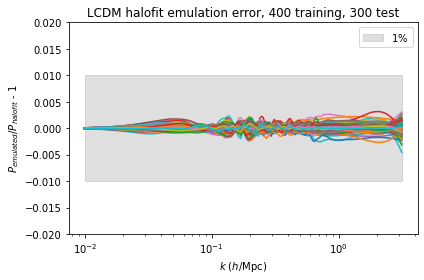

In [10]:
for i in range(num_points_test):
    for j in range(1):
        plt.semilogx(ks, emulated_pks[i][j]/pks_test_nl[j][i] -1)
#         if emulated_pks[i][j][70]/pks_test_nl[j][i][70] - 1 >= 0.02:
#             print(i)
plt.fill_between(ks,-0.01,0.01, alpha=0.25, label='$1\%$',color='gray')
plt.legend(loc='best')
plt.xlabel('$k$ ($h$/Mpc)')
plt.ylabel('$P_{emulated}/P_{halofit}$ - 1')
plt.ylim([-0.02,0.02])
plt.title(f'LCDM halofit emulation error, {num_points} training, {num_points_test} test')
plt.tight_layout()
plt.savefig(f'hf_lcdm_{num_points}vs{num_points_test}_cola_lhs_{N_pc}pcs.pdf')

em_errs = []
for j in range(len(redshifts_ee2)):
    em_errs.append([])
    for i in range(num_points_test):
        em_errs[j].append(emulated_pks[i][j]/pks_test_nl[j][i] -1)

for j in range(len(redshifts_ee2)):
    z_str =  "{:.3f}".format(redshifts_ee2[j]) 
    np.savetxt(f'/home/grads/data/jonathan/cola_lsst/data/hf_emu_errs/gp/lcdm/BACCO/{num_points}vs{num_points_test}_{fac_percent}pct/hf_err_z{z_str}.txt', em_errs[j])

np.savetxt('/home/grads/data/jonathan/cola_lsst/data/hf_emu_errs/gp/ks.txt',ks)

zs_emus = [0,0.5,1,2,3]
n_pts=1000
em_nn = []
for j in range(len(zs_emus)):
    z_str1 = "{:.1f}".format(zs_emus[j]) 
    z_str2 = "{:.3f}".format(zs_emus[j])
    em_errs_nn = np.loadtxt(f'/home/grads/data/jonathan/cola_lsst/data/hf_emu_errs/nn/wcdm/HALOFIT_EMU_ERRORS_WCDM_Z{z_str1}_{n_pts}PTS_TEST50.txt')
    print(len(em_errs_nn))
    np.savetxt(f'/home/grads/data/jonathan/cola_lsst/data/hf_emu_errs/nn/wcdm/{n_pts}/hf_err_z{z_str2}.txt', em_errs_nn)

zs_emus = [0,0.5,1,2,3]
n_pts=1000
for j in range(len(zs_emus)):
    z_str1 = "{:.1f}".format(zs_emus[j]) 
    z_str2 = "{:.3f}".format(zs_emus[j])
    em_errs_pce = np.loadtxt(f'/home/grads/data/jonathan/cola_lsst/data/hf_emu_errs/pce/wcdm/{n_pts}_pce_wcdm_50_test_z={z_str1}.txt')
    print(len(em_errs_pce))
    np.savetxt(f'/home/grads/data/jonathan/cola_lsst/data/hf_emu_errs/pce/wcdm/{n_pts}/hf_err_z{z_str2}.txt', em_errs_pce)